### GBDT梯度提升树应用示例

#### 数据加载

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

X,y = datasets.load_iris(return_X_y = True)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 1124)

#### 普通决策树

In [2]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8421052631578947

#### GBDT梯度提升树

In [3]:
clf = GradientBoostingClassifier(subsample=0.8,learning_rate = 0.005)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.9473684210526315

In [4]:
clf[0]

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x1EA1ED98E40),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x1EA1ED98E40),
       DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x1EA1ED98E40)],
      dtype=object)

### GBDT算法剖根问底算法底层原理展示

#### 构建数据

In [5]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import graphviz

X = np.arange(1,11).reshape(-1,1)
y = np.array([0,0,0,1,1]*2)
display(X,y)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1])

#### GBDT建模训练预测

In [8]:
# 默认情况下，损失函数就是Log-loss == 交叉熵！
clf = GradientBoostingClassifier(n_estimators=3,learning_rate=0.1,max_depth=1)
clf.fit(X,y)
y_ = clf.predict(X)


print('真实的类别：',y)
print('算法的预测：',y_)

proba_ = clf.predict_proba(X)
print('预测概率是：\n',proba_)

真实的类别： [0 0 0 1 1 0 0 0 1 1]
算法的预测： [0 0 0 0 0 0 0 0 1 1]
预测概率是：
 [[0.66466915 0.33533085]
 [0.66466915 0.33533085]
 [0.66466915 0.33533085]
 [0.6126304  0.3873696 ]
 [0.6126304  0.3873696 ]
 [0.6126304  0.3873696 ]
 [0.6126304  0.3873696 ]
 [0.6126304  0.3873696 ]
 [0.46804618 0.53195382]
 [0.46804618 0.53195382]]


#### GBDT可视化

第一棵树

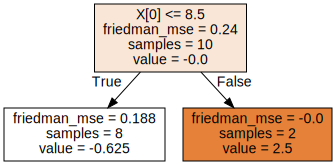

In [35]:
dot_data = tree.export_graphviz(clf[0,0],filled = True)
graph = graphviz.Source(dot_data)
graph

第二棵树

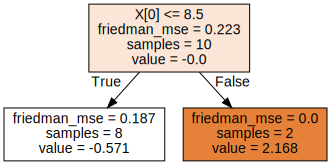

In [36]:
dot_data = tree.export_graphviz(clf[1,0],filled = True)
graph = graphviz.Source(dot_data)
graph

第三棵树

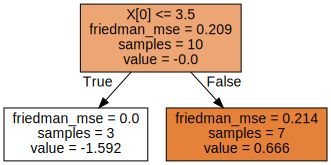

In [37]:
dot_data = tree.export_graphviz(clf[2,0],filled = True)
graph = graphviz.Source(dot_data)
graph

#### 初始值计算

$F_0(x)= log\frac{\sum\limits_{i=1}^Ny_i}{\sum\limits_{i=1}^N(1 -y_i)}$

In [12]:
F0 = np.log(y.sum()/(1-y).sum())
F0

-0.40546510810816444

In [13]:
# 扩展为10个样本
F0 = np.array([F0]*10)
F0

array([-0.40546511, -0.40546511, -0.40546511, -0.40546511, -0.40546511,
       -0.40546511, -0.40546511, -0.40546511, -0.40546511, -0.40546511])

残差计算

In [14]:
# 残差，F0带入sigmoid计算的即是初始概率
residual0 = y - 1/(1 + np.exp(-F0))
residual0

array([-0.4, -0.4, -0.4,  0.6,  0.6, -0.4, -0.4, -0.4,  0.6,  0.6])

#### 手写代码拟合第一棵树

根据残差的mse，计算最佳分裂条件

In [15]:
# 未经分裂mse
lower_mse = ((residual0 - residual0.mean())**2).mean()
lower_mse

0.24

<font size = 6>$\rm mse = ((residual - residual.mean())^2).mean()$</font>

In [16]:
X.ravel()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [18]:
best_split = {}
for i in range(10):
    if i == 9:# 所有的样本，都在左侧叶节点
        mse = ((residual0 - residual0.mean())**2).mean()
    else:
        left = residual0[:i+1]
        right = residual0[i+1:]
        left_mse = ((left - left.mean())**2).mean()
        right_mse = ((right - right.mean())**2).mean()
        mse = left_mse * len(left)/10 + right_mse * len(right)/10
        if lower_mse > mse:
            lower_mse = mse
            best_split.clear()
            best_split['X[0] <= '] = X[i:i+2].mean()
        print('从第%d个进行分类'%(i + 1),np.round(mse,3))
print('最小的mse是：',lower_mse)
print('最佳的裂分条件是：',best_split)

从第1个进行分类 0.222
从第2个进行分类 0.2
从第3个进行分类 0.171
从第4个进行分类 0.225
从第5个进行分类 0.24
从第6个进行分类 0.233
从第7个进行分类 0.21
从第8个进行分类 0.15
从第9个进行分类 0.2
最小的mse是： 0.15
最佳的裂分条件是： {'X[0] <= ': 8.5}


决策树叶节点预测值（相当于负梯度）  
<font size = 6>$\gamma_{mj} = \frac{\sum\limits_{x_i \in R_{mj}}\widetilde{y}_i}{\sum_\limits{x_i \in R_{mj}}(y_i - \widetilde{y}_i)(1 - y_i + \widetilde{y}_i)}$​​​</font>

In [20]:
gamma1 = residual0[:8].sum()/((y[:8] - residual0[:8])*(1 - y[:8] + residual0[:8])).sum()
np.round(gamma1,3)

-0.625

In [21]:
gamma2 = residual0[-2:].sum()/((y[-2:] - residual0[-2:])*(1 - y[-2:] + residual0[-2:])).sum()
np.round(gamma2,3)

2.5

#### 手写代码拟合第二棵树

In [22]:
gamma = np.array([gamma1] * 8 + [gamma2] * 2)
gamma

array([-0.625, -0.625, -0.625, -0.625, -0.625, -0.625, -0.625, -0.625,
        2.5  ,  2.5  ])

梯度提升

In [23]:
learning_rate=0.1
F1 = F0 + gamma * learning_rate
F1

array([-0.46796511, -0.46796511, -0.46796511, -0.46796511, -0.46796511,
       -0.46796511, -0.46796511, -0.46796511, -0.15546511, -0.15546511])

残差计算

In [24]:
residual1 = y - 1/(1 + np.exp(-F1))
residual1

array([-0.38509799, -0.38509799, -0.38509799,  0.61490201,  0.61490201,
       -0.38509799, -0.38509799, -0.38509799,  0.53878818,  0.53878818])

根据当前树的残差，计算最佳裂分条件

In [25]:
lower_mse = ((residual1 - residual1.mean())**2).mean()
print('第二棵树未经分裂的初始mse是：',np.round(lower_mse,3))
best_split = {}
for i in range(10):
    if i == 9:# 所有的样本，都在左侧叶节点
        mse = ((residual1 - residual1.mean())**2).mean()
    else:
        left = residual1[:i+1]
        right = residual1[i+1:]
        left_mse = ((left - left.mean())**2).mean()
        right_mse = ((right - right.mean())**2).mean()
        mse = left_mse * len(left)/10 + right_mse * len(right)/10
        if lower_mse > mse:
            lower_mse = mse
            best_split.clear()
            best_split['X[0] <= '] = X[i:i+2].mean()
        print('从第%d个进行分类'%(i + 1),np.round(mse,3))
print('最小的mse是：',lower_mse)
print('最佳的裂分条件是：',best_split)

第二棵树未经分裂的初始mse是： 0.223
从第1个进行分类 0.206
从第2个进行分类 0.186
从第3个进行分类 0.159
从第4个进行分类 0.211
从第5个进行分类 0.222
从第6个进行分类 0.219
从第7个进行分类 0.2
从第8个进行分类 0.15
从第9个进行分类 0.19
最小的mse是： 0.15
最佳的裂分条件是： {'X[0] <= ': 8.5}


第二棵树叶节点预测值计算

In [26]:
gamma1 = residual1[:8].sum()/((y[:8] - residual1[:8])*(1 - y[:8] + residual1[:8])).sum()
print('第二棵树左侧叶节点预测值是：',np.round(gamma1,3))

gamma2 = residual1[-2:].sum()/((y[-2:] - residual1[-2:])*(1 - y[-2:] + residual1[-2:])).sum()
print('第二棵树右侧叶节点预测值是：',np.round(gamma2,3))

第二棵树左侧叶节点预测值是： -0.571
第二棵树右侧叶节点预测值是： 2.168


#### 手写代码拟合第三棵树

第二棵树的叶节点预测值（负梯度）

In [27]:
gamma = np.array([gamma1] * 8 + [gamma2] * 2)
gamma

array([-0.57052111, -0.57052111, -0.57052111, -0.57052111, -0.57052111,
       -0.57052111, -0.57052111, -0.57052111,  2.16820117,  2.16820117])

在上一棵树的基础上，进行梯度提升

In [28]:
F2 = F1 + gamma * learning_rate
F2

array([-0.52501722, -0.52501722, -0.52501722, -0.52501722, -0.52501722,
       -0.52501722, -0.52501722, -0.52501722,  0.06135501,  0.06135501])

第三棵树的残差

In [29]:
residual2 = y - 1/(1 + np.exp(-F2))
residual2

array([-0.37167979, -0.37167979, -0.37167979,  0.62832021,  0.62832021,
       -0.37167979, -0.37167979, -0.37167979,  0.48466606,  0.48466606])

根据当前这棵树的残差，重新计算最佳裂分条件

In [31]:
lower_mse = ((residual2 - residual2.mean())**2).mean()
print('第三棵树未经分裂的初始mse是：',np.round(lower_mse,3))
best_split = {}
for i in range(10):
    if i == 9:# 所有的样本，都在左侧叶节点
        mse = ((residual2 - residual2.mean())**2).mean()
    else:
        left = residual2[:i+1]
        right = residual2[i+1:]
        left_mse = ((left - left.mean())**2).mean()
        right_mse = ((right - right.mean())**2).mean()
        mse = left_mse * len(left)/10 + right_mse * len(right)/10
        if lower_mse > mse:
            lower_mse = mse
            best_split.clear()
            best_split['X[0] <= '] = X[i:i+2].mean()
        print('从第%d个进行分类'%(i + 1),np.round(mse,3))
print('最小的mse是：',lower_mse)
print('最佳的裂分条件是：',best_split)

第三棵树未经分裂的初始mse是： 0.209
从第1个进行分类 0.194
从第2个进行分类 0.174
从第3个进行分类 0.15
从第4个进行分类 0.199
从第5个进行分类 0.208
从第6个进行分类 0.207
从第7个进行分类 0.192
从第8个进行分类 0.15
从第9个进行分类 0.183
最小的mse是： 0.1497502190152274
最佳的裂分条件是： {'X[0] <= ': 3.5}


第三棵树叶节点预测值计算

In [34]:
gamma1 = residual2[:3].sum()/((y[:3] - residual2[:3])*(1 - y[:3] + residual2[:3])).sum()
print('第三棵树左侧叶节点预测值是：',np.round(gamma1,3))

gamma2 = residual2[-7:].sum()/((y[-7:] - residual2[-7:])*(1 - y[-7:] + residual2[-7:])).sum()
print('第三棵树右侧叶节点预测值是：',np.round(gamma2,3))

第三棵树左侧叶节点预测值是： -1.592
第三棵树右侧叶节点预测值是： 0.666


#### 概率计算

计算第三棵树F3(x)

In [38]:
gamma = np.array([gamma1] * 3 + [gamma2] * 7)
gamma

array([-1.59154518, -1.59154518, -1.59154518,  0.66634692,  0.66634692,
        0.66634692,  0.66634692,  0.66634692,  0.66634692,  0.66634692])

In [39]:
F3 = F2 + learning_rate * gamma
F3

array([-0.68417174, -0.68417174, -0.68417174, -0.45838253, -0.45838253,
       -0.45838253, -0.45838253, -0.45838253,  0.1279897 ,  0.1279897 ])

根据第三棵梯度提升结果F3，转变为概率

In [42]:
p = 1/(1 + np.exp(-F3))
p_ = np.c_[1-p,p]
p_

array([[0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.46804618, 0.53195382],
       [0.46804618, 0.53195382]])

In [44]:
p_.argmax(axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1], dtype=int64)

In [41]:
clf.predict_proba(X)

array([[0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.46804618, 0.53195382],
       [0.46804618, 0.53195382]])